In [1]:
import lsh_py_wrapper as pyLSH
import knn_py_wrapper as pyKNN
import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

In [2]:
#cuda for GPU, cpu for CPU
mode = torch.device('cuda')

In [3]:
data_file = "../data/5000exp50d.csv"

In [4]:
# Parameters
learn_rate = 1e-4
iterations = 10000
loss_margin = 50            # Margin for Contrastive Loss
pair_selection = "random"   # random, knn, or lsh

In [5]:
# Number of intermediate checkpoints to graph
checkpoints = 3

In [6]:
def rand_pairs(data, labels):
    perm = torch.randperm(data.size(0))
    equals = torch.eq(labels, labels[perm]).squeeze().to(torch.float)
    dists = torch.sum((data - data[perm]) ** 2, 1)
    return equals, dists

In [7]:
def knn_pairs(data, labels):
    data = data.cpu().detach().numpy().flatten("F")
    ind = pyKNN.gpu_knn(data, data, 3, 2)
    ind = torch.tensor(np.asarray(list(ind)))
    print(ind)
    print(type(ind))

In [8]:
def lsh_pairs(data, labels, it, hash_ptr):
    #LSH parameters
    refresh = 10
    num_tables = 5
    projection_dim = 3
    bucket_wid = 3
    probe_bins = 3
    data = data.cpu().detach().numpy().flatten().tolist()[:9]

    if it % refresh == 0:
        hash_ptr = pyLSH.lsh_hash(hash_ptr, 3, num_tables, projection_dim, bucket_wid, data)
    ind = pyLSH.lsh_search(hash_ptr, 2, probe_bins, len(data), data, data)
    ind = torch.tensor(np.asarray(list(ind)))    

In [9]:
def graph_loss(losses):
    plt.plot(range(0, 100 * len(losses), 100), losses)
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.savefig('../results/loss_over_training.png')

In [10]:
def graph_points(points, labels, iteration, fname):
    points = points.cpu().detach().numpy()
    x1 = points[:, 0]
    x2 = points[:, 1]
    x3 = points[:, 2]
    y = np.squeeze(labels.cpu().detach().numpy())

    colors = ['red', 'blue']
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(x1, x2, x3, c=y, cmap=matplotlib.colors.ListedColormap(colors))
    plt.savefig('../results/checkpoint_' + fname)

In [11]:
# Reading Data
data = []
labels = []
for ind, line in enumerate(open(data_file)):
    labels.append(np.array(int(line[0])))
    data.append(np.array(np.fromstring(line.split(',', 1)[1], sep = ',')))
    
data = np.column_stack(data)
labels = np.column_stack(labels)

In [12]:
# Numpy matrices to torch tensor of Float type
labels = torch.tensor(labels.transpose()).to(torch.float)
data = torch.tensor(data.transpose()).to(torch.float)

# Move to GPU if mode is CUDA
if mode == torch.device('cuda'):
    data = data.cuda()
    labels = labels.cuda()

In [13]:
# NN Architecture
D_in, D_1, D_2, D_3, D_4, D_out = data.shape[1], 100, 50, 25, 10, 3

# Initial weights
w1 = torch.nn.init.xavier_uniform_(torch.randn(D_in, D_1, device=mode, requires_grad=True))
w2 = torch.nn.init.xavier_uniform_(torch.randn(D_1, D_2, device=mode, requires_grad=True))
w3 = torch.nn.init.xavier_uniform_(torch.randn(D_2, D_3, device=mode, requires_grad=True))
w4 = torch.nn.init.xavier_uniform_(torch.randn(D_3, D_4, device=mode, requires_grad=True))
w5 = torch.nn.init.xavier_uniform_(torch.randn(D_4, D_out, device=mode, requires_grad=True))

Commence Learning!!!
Iteration: 0 	|	Initial Loss: 1249
Iteration: 100 	|	Average Loss (last 100): 1244
Iteration: 200 	|	Average Loss (last 100): 1037
Iteration: 300 	|	Average Loss (last 100): 903
Iteration: 400 	|	Average Loss (last 100): 886
Iteration: 500 	|	Average Loss (last 100): 876
Iteration: 600 	|	Average Loss (last 100): 854
Iteration: 700 	|	Average Loss (last 100): 821
Iteration: 800 	|	Average Loss (last 100): 817
Iteration: 900 	|	Average Loss (last 100): 810
Iteration: 1000 	|	Average Loss (last 100): 808
Iteration: 1100 	|	Average Loss (last 100): 805
Iteration: 1200 	|	Average Loss (last 100): 805
Iteration: 1300 	|	Average Loss (last 100): 800
Iteration: 1400 	|	Average Loss (last 100): 800
Iteration: 1500 	|	Average Loss (last 100): 799
Iteration: 1600 	|	Average Loss (last 100): 798
Iteration: 1700 	|	Average Loss (last 100): 796
Iteration: 1800 	|	Average Loss (last 100): 794
Iteration: 1900 	|	Average Loss (last 100): 791
Iteration: 2000 	|	Average Loss (last 1

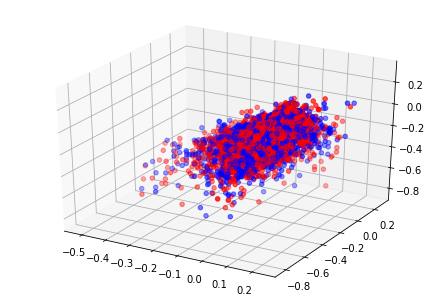

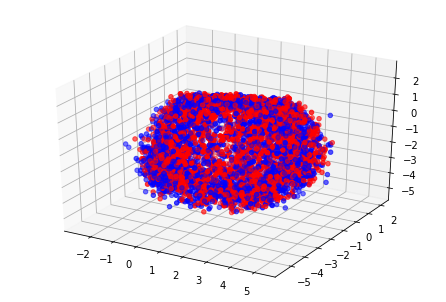

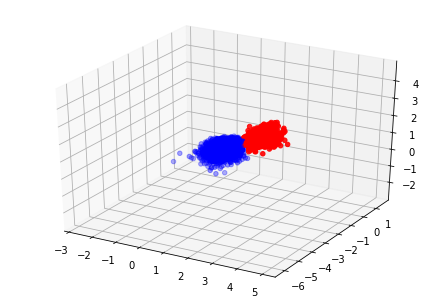

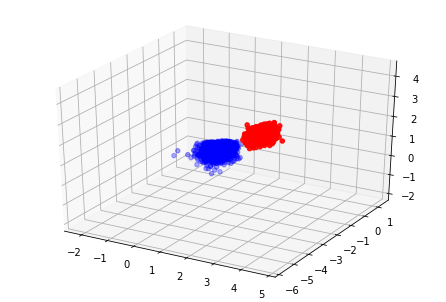

In [14]:
print("Commence Learning!!!")
accumulator = 0
losses = []
lsh_hash_ptr = 0
checkpoint_count = 0
for it in range(iterations):
    # Forward Pass
    results = data.mm(w1).clamp(min=0).mm(w2).clamp(min=0).mm(w3).clamp(min=0).mm(w4).clamp(min=0).mm(w5)

    #Loss Calculation
    if pair_selection == 'random':
        if_same, euclidean_dist = rand_pairs(results, labels)
    elif pair_selection == 'knn':
        if_same, euclidean_dist = knn_pairs(results, labels)
    elif pair_selection == 'lsh':
        if_same, euclidean_dist, lsh_hash = lsh_pairs(results, labels, it, lsh_hash_ptr)
        break
        
    loss = torch.mean((if_same) * torch.pow(euclidean_dist, 2) +
            (1 - if_same) * torch.pow(torch.clamp(loss_margin - euclidean_dist, min=0), 2))
    
    #print("Iteration:", it, "\t\tLoss:", loss.item())
    accumulator += loss.item()

    #Backward Pass
    loss.backward()

    #print(w1.grad)
    
    with torch.no_grad():
        # Update Gradients
        w1 -= learn_rate * w1.grad
        w2 -= learn_rate * w2.grad
        w3 -= learn_rate * w3.grad
        w4 -= learn_rate * w4.grad
        w5 -= learn_rate * w5.grad

        # Manually zero the gradients after running the backward pass
        w1.grad.zero_(); w2.grad.zero_(); w3.grad.zero_(); w4.grad.zero_(); w5.grad.zero_()

    if it % 100 == 0:
        if it == 0:
            print("Iteration:", it, "\t|\tInitial Loss:", round(accumulator))
            losses.append(accumulator)
        else:
            avg_loss = accumulator / 100
            print("Iteration:", it, "\t|\tAverage Loss (last 100):", round(avg_loss))
            losses.append(avg_loss)
        accumulator = 0

    if it % round(iterations / checkpoints) == 0:
        checkpoint_count += 1
        graph_points(results, labels, it, str(checkpoint_count))

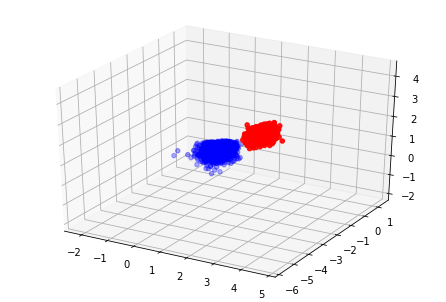

In [15]:
graph_points(results, labels, it, "final")

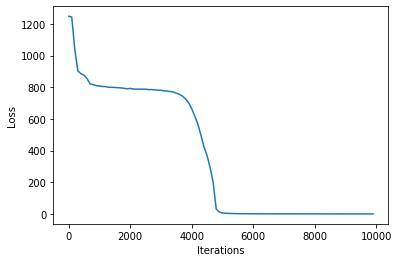

In [16]:
graph_loss(losses)